In [49]:
%tensorflow_version 1.x
!git clone https://github.com/NVlabs/stylegan2-ada.git

import sys
import pickle
import os
import numpy as np

import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

sys.path.insert(0, "/content/stylegan2-ada")

import dnnlib
import dnnlib.tflib as tflib

def seed2vec(Gs, seed):
  rnd = np.random.RandomState(seed)
  return rnd.randn(1, *Gs.input_shape[1:])

def init_random_state(Gs, seed):
  rnd = np.random.RandomState(seed) 
  noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]

def display_image(data, scale):
  img = PIL.Image.fromarray(data, 'RGB')
  width, height = img.size

  img = img.resize((
        int(width * scale), 
        int(height * scale)), 
        PIL.Image.ANTIALIAS)
  display(img)

def generate_image(Gs, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + Gs.input_shapes[1][1:])
    images = Gs.run(z, label, **Gs_kwargs) # [minibatch, height, width, channel]
    return images[0]

fatal: destination path 'stylegan2-ada' already exists and is not an empty directory.


Now load the correct GAN, I have several links below that correspond to both the NVIDIA faces GAN, as well as my own.

In [50]:
import IPython.display

URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
tflib.init_tf()
print('Loading networks from "%s"...' % URL)
with dnnlib.util.open_url(URL) as fp:
    _G, _D, Gs = pickle.load(fp)

Loading networks from "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"...


# Generate and View GANS from Seeds

A GAN is actually created from a 512 number latent vector.  However, for now it is easier to just use seeds to build this 512 vector.  This code generates images between two seed numbers.

Seed 3000


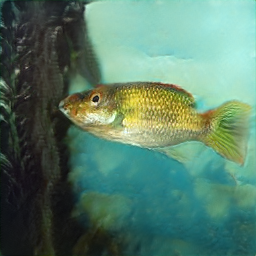

Seed 3001


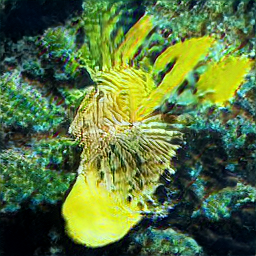

Seed 3002


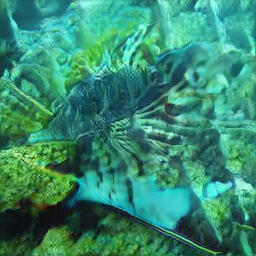

In [51]:
# Choose your own starting and ending seed.
SEED_FROM = 3000
SEED_TO = 3003

SCALE = 1.0
# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  init_random_state(Gs, 10)
  z = seed2vec(Gs, i)
  img = generate_image(Gs, z, 1.0)
  display_image(img, SCALE)

# Generate a Large Number of Images and Download

Generate a potentially large number of images to download.  

In [52]:
# Choose your own starting and ending seed.
SEED_FROM = 3000
SEED_TO = 3100

from tqdm.notebook import tqdm

!mkdir /content/images/

# Generate the images for the seeds.
for i in tqdm(range(SEED_FROM, SEED_TO)):
  init_random_state(Gs, 10)
  z = seed2vec(Gs, i)
  img = generate_image(Gs, z, 1.0)
  PIL.Image.fromarray(img, 'RGB').save(f'/content/images/seed-{i}.jpg')

mkdir: cannot create directory ‘/content/images/’: File exists


Zip the generated images.

In [53]:
!zip -qr images.zip /content/images 

Download generated images, this can take awhile, even before the actual download starts. It might also work better to map GDrive and copy the fies there, if you have a large number of files.

In [54]:
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Morph Video

You can create a video that shows the progression through two GAN seeds.  This technique creates a very cool "morph" effect. 

![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

In [55]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [3004,3031,3033,3111,3191,3253]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(Gs, SEEDS[i])
  v2 = seed2vec(Gs, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    init_random_state(Gs, 10)
    img = generate_image(Gs, current, 1.0)
    PIL.Image.fromarray(img, 'RGB').save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

Download the video.

In [56]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [57]:
START_SEED = 3172

current = seed2vec(Gs, START_SEED)

Next, generate display the current vector. You will return to this point for each iteration of the finetuning.

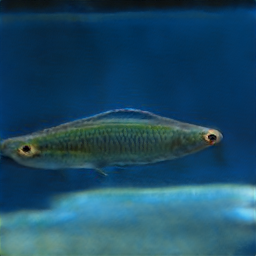

In [58]:
init_random_state(Gs, 10)
img = generate_image(Gs, current, 1.0)

SCALE = 1.0
display_image(img, SCALE)

Choose an explore size, this is the number of differnt potential images that will be chosen by moving in 10 different directions.  Run this code once initially, and then again anytime you wish to change the 10 directions you are exploring.  You might change the 10 directions if you are no longer seeing improvements.

In [59]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

Direction 0


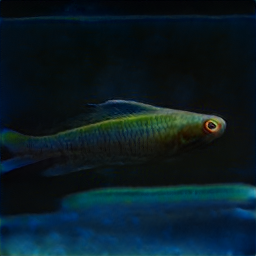

Direction 1


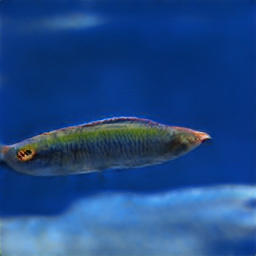

Direction 2


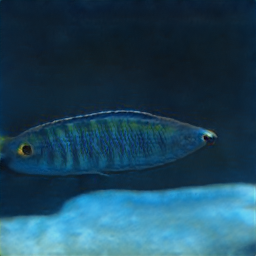

Direction 3


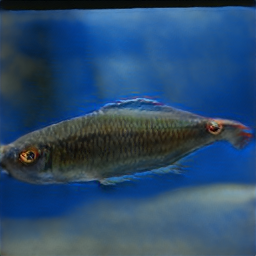

Direction 4


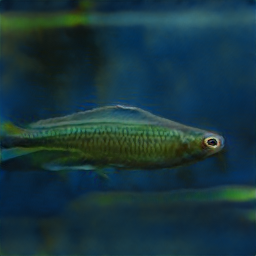

Direction 5


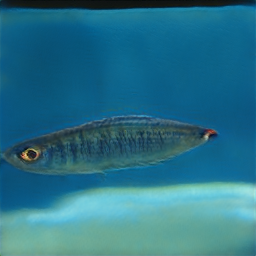

Direction 6


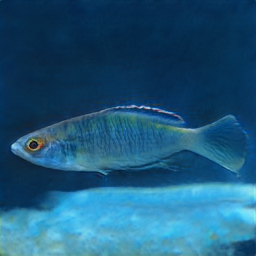

Direction 7


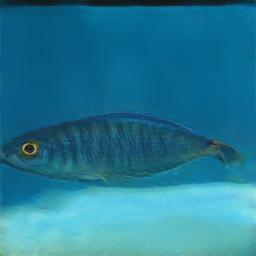

Direction 8


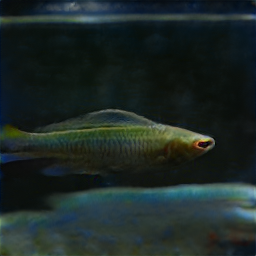

Direction 9


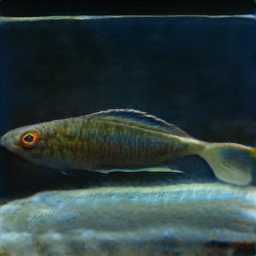

Direction 10


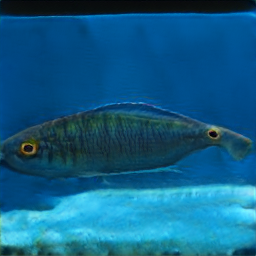

Direction 11


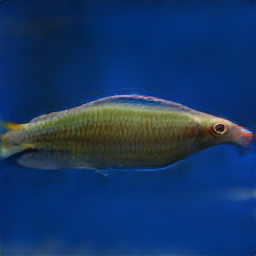

Direction 12


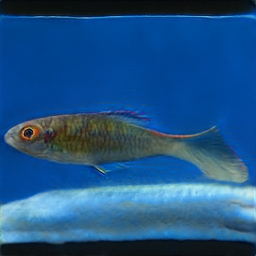

Direction 13


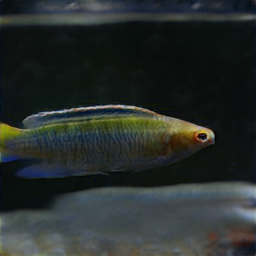

Direction 14


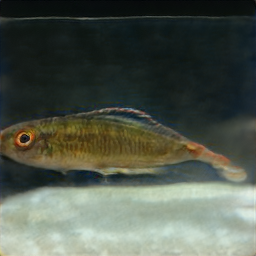

Direction 15


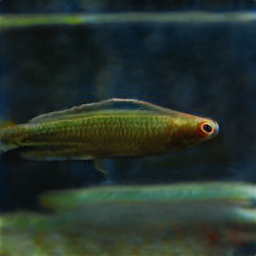

Direction 16


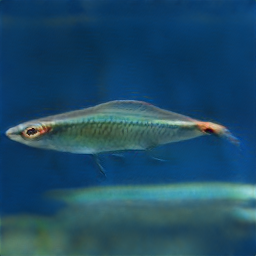

Direction 17


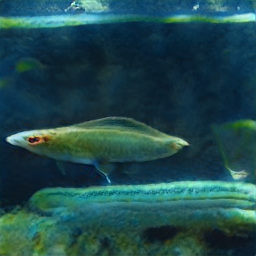

Direction 18


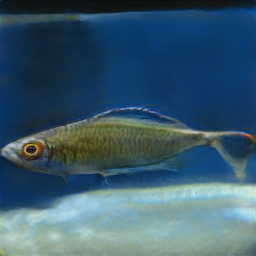

Direction 19


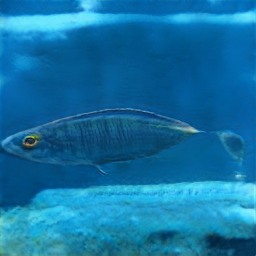

Direction 20


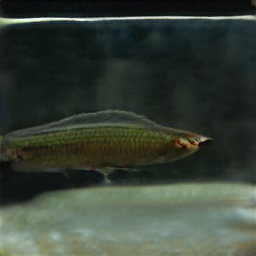

Direction 21


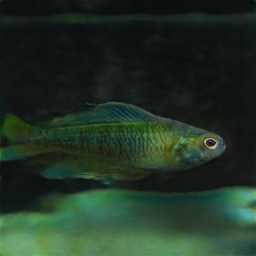

Direction 22


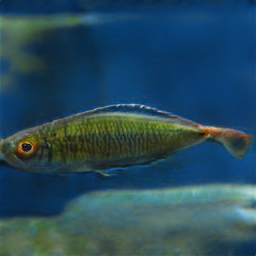

Direction 23


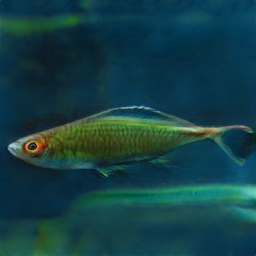

Direction 24


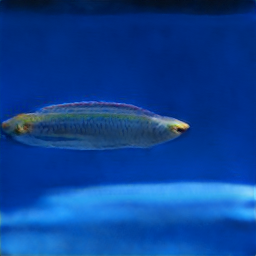

In [60]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 1.0

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  init_random_state(Gs, 10)
  z = current + mv
  img = generate_image(Gs, z, 1.0)
  display_image(img, SCALE)